In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary
from utilities import plot_fault_counts, plot_histogram, plot_rose_diagram, append_param_to_cmd, normalize, plot_fault_points

from tqdm import trange

---

---

# Data Generation

In [2]:
# ─── 0) User picks parameters ────────────────────────────────────────────
mask_mode    = 0 # 0 binary (0, 1) | 1 Multiclass (0, 1, 2), normal and inverse faults
num_pairs    = 10
cube_size    = 128
ricker_freq = (5, 35)      # Hz or (min, max)
seismic_noise = (0.1, 0.5)      # None | float | (min, max)
ricker_dt    = 0.002
wavelet_len  = 0.2        # s
num_gauss    = (2,10)     # int or (min, max)
num_faults = (0,4)       # int or (min, max) faults per cube
max_disp   = (75, 100)   # int or (min, max) max displacement magnitude per cube
strike     = (0,360)      # deg or (min, max) strike angle per fault
dip        = (35,80) # deg or (min, max) dip angle per fault
output_format = "npy" # npy, npz, or dat
train_split = 0.7 # 70% for training
val_split = 0.15 # 15% for validation

In [3]:
# ─── 1) Call your script (passing parameters from notebook variables) ─────────────────
script = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py"
base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data")

# Create output directory if it doesn't exist
os.makedirs(base_out, exist_ok=True)

print(f"Running script: {script}")
print(f"Output directory: {base_out}")

# Calculate the number of samples for each set
num_train = int(np.floor(num_pairs * train_split))
num_val = num_pairs - num_train

# Construct the command
cmd = [
    "python", script,
    "--num-pairs",     str(num_pairs),
    "--size",          str(cube_size),
    "--dt",            str(ricker_dt),
    "--length",        str(wavelet_len),
    "--mask-mode",     str(mask_mode),
    "--format",        output_format,
    "--output-dir",    base_out,
    "--train-split",   str(train_split),
    "--val-split",     str(val_split),
    "--faults",        f"{num_faults[0]},{num_faults[1]}",
    "--max-disp",      f"{max_disp[0]},{max_disp[1]}",
    "--strike",        f"{strike[0]},{strike[1]}",
    "--dip",           f"{dip[0]},{dip[1]}",
    "--freq",          f"{ricker_freq[0]},{ricker_freq[1]}",
    "--num-gaussians", f"{num_gauss[0]},{num_gauss[1]}",
    "--noise",         f"{seismic_noise[0]},{seismic_noise[1]}",
]

# Run the command
result = subprocess.run(cmd, text=True) #result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("Data generation successful!")
    print(result.stdout)
else:
    print("Data generation failed.")
    print(result.stderr)

# Data generation statistics
stats = {
    "total_pairs": num_pairs,
    "train_pairs": num_train,
    "validation_pairs": num_val,
}

# Save statistics to a JSON file
stats_file_path = os.path.join(base_out, "stats_data.json")
with open(stats_file_path, 'w') as f:
    json.dump(stats, f, indent=4)

print(f"Data generation complete. Statistics saved to {stats_file_path}")

Running script: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py
Output directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/train
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/validation

Data split: 7 train, 3 validation.
Output format: npy

Starting data generation for 10 pairs...


Generating Cubes:  90%|█████████ | 9/10 [00:04<00:00,  2.36it/s]


--- Saving Statistics Files ---
Saved full statistics to /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_full.json
Saved train statistics to /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_train.json
Saved validation statistics to /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_validation.json

[2025-07-02 15:39:25] Generation complete.
 • train/seis/ → /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/train/seis
 • train/fault/ → /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/train/fault
 • validation/seis/ → /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/validation/seis
 • validation/fault/ → /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/validation/fault
Done ✅
Data generation successful!
None
Data generation complete. St

Generating Cubes: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [4]:
# ─── 2) Check the output ────────────────────────────────────────────────
# Check the total number of files created across all splits
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len(os.listdir(seis_dir))

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs.")



Successfully generated 10 file pairs.


In [5]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

append_param_to_cmd(cmd, "freq", ricker_freq)
append_param_to_cmd(cmd, "num-gaussians", num_gauss)
append_param_to_cmd(cmd, "noise", seismic_noise)
append_param_to_cmd(cmd, "faults", num_faults)
append_param_to_cmd(cmd, "max-disp", max_disp)
append_param_to_cmd(cmd, "strike", strike)
append_param_to_cmd(cmd, "dip", dip)

In [6]:
print("\nCommand to run:")
print(" ".join(cmd)) # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")

# Check if the expected number of files were generated
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len([f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat"))])

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs across all splits.")


Command to run:
python /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py --num-pairs 10 --size 128 --dt 0.002 --length 0.2 --mask-mode 0 --format npy --output-dir /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data --train-split 0.7 --val-split 0.15 --faults 0,4 --max-disp 75,100 --strike 0,360 --dip 35,80 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --faults 0,4 --max-disp 75,100 --strike 0,360 --dip 35,80

Running subprocess...
=== STDOUT ===
 Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/train
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/validation

Data split: 7 train, 3 validation.
Output format: npy

Starting data generation for 10 pairs...

--- Saving Statistics Files ---
Saved full statistics to /Users/roderickperez/Documents/DS_Projects/fau

In [7]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────

# Define the base output directory
#base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Define the splits and their expected number of files
splits = {
    "train": num_train,
    "validation": num_val
}

# Check if the expected number of files were generated for each split
for split, expected_files in splits.items():
    seis_dir = os.path.join(base_out, split, "seis")
    fault_dir = os.path.join(base_out, split, "fault")

    if os.path.exists(seis_dir):
        files = sorted(f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat")))
        n_files = len(files)
        if n_files != expected_files:
            print(f"Warning: Mismatch in generated files for '{split}' split. Expected {expected_files}, found {n_files} in {seis_dir}")
    else:
        print(f"Warning: Seismic output directory not found for '{split}' split: {seis_dir}")

    if not os.path.exists(fault_dir):
        print(f"Warning: Fault output directory not found for '{split}' split: {fault_dir}")

# Load the statistics files
stats_data = {}
for split in splits.keys():
    stats_file_path = os.path.join(base_out, f"statistics_{split}.json")
    if os.path.exists(stats_file_path):
        with open(stats_file_path, 'r') as f:
            stats_data[split] = json.load(f)
            print(f"Successfully loaded statistics for '{split}' split.")
    else:
        print(f"Warning: Statistics file not found for '{split}' split: {stats_file_path}")

# Load the full statistics file
full_stats_path = os.path.join(base_out, "statistics_full.json")
if os.path.exists(full_stats_path):
    with open(full_stats_path, 'r') as f:
        full_stats = json.load(f)
        print("Successfully loaded full statistics.")
else:
    print(f"Warning: Full statistics file not found: {full_stats_path}")

Successfully loaded statistics for 'train' split.
Successfully loaded statistics for 'validation' split.
Successfully loaded full statistics.


In [8]:
# Load all statistics: full, prediction, train, and validation
stats_files = {
    "full": os.path.join(base_out, "statistics_full.json"),
    "train": os.path.join(base_out, "statistics_train.json"),
    "validation": os.path.join(base_out, "statistics_validation.json")
}

all_stats_data = {}
for split, path in stats_files.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                all_stats_data[split] = json.load(f)
            print(f"Loaded statistics for '{split}' from {path}")
        except Exception as e:
            print(f"Error loading statistics for '{split}': {e}")
            all_stats_data[split] = None
    else:
        print(f"Statistics file not found for '{split}': {path}")
        all_stats_data[split] = None

Loaded statistics for 'full' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_full.json
Loaded statistics for 'train' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_train.json
Loaded statistics for 'validation' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/data/statistics_validation.json



--- Displaying Statistics and Plots for full data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count  10.000000    10.000000      10.000000             10.000000   
mean   22.129447     0.260792       6.500000              2.700000   
std     7.275947     0.098724       3.472111              1.418136   
min    11.227347     0.109171       2.000000              0.000000   
25%    17.978616     0.210320       3.250000              2.000000   
50%    22.294984     0.233988       7.500000              3.000000   
75%    27.396851     0.307651       9.750000              4.000000   
max    33.250980     0.443913      10.000000              4.000000   

       max_disp_used  
count      10.000000  
mean       89.400000  
std         8.859396  
min        76.000000  
25%        81.500000  
50%        92.500000  
75%        95.750000  
max       100.000000  


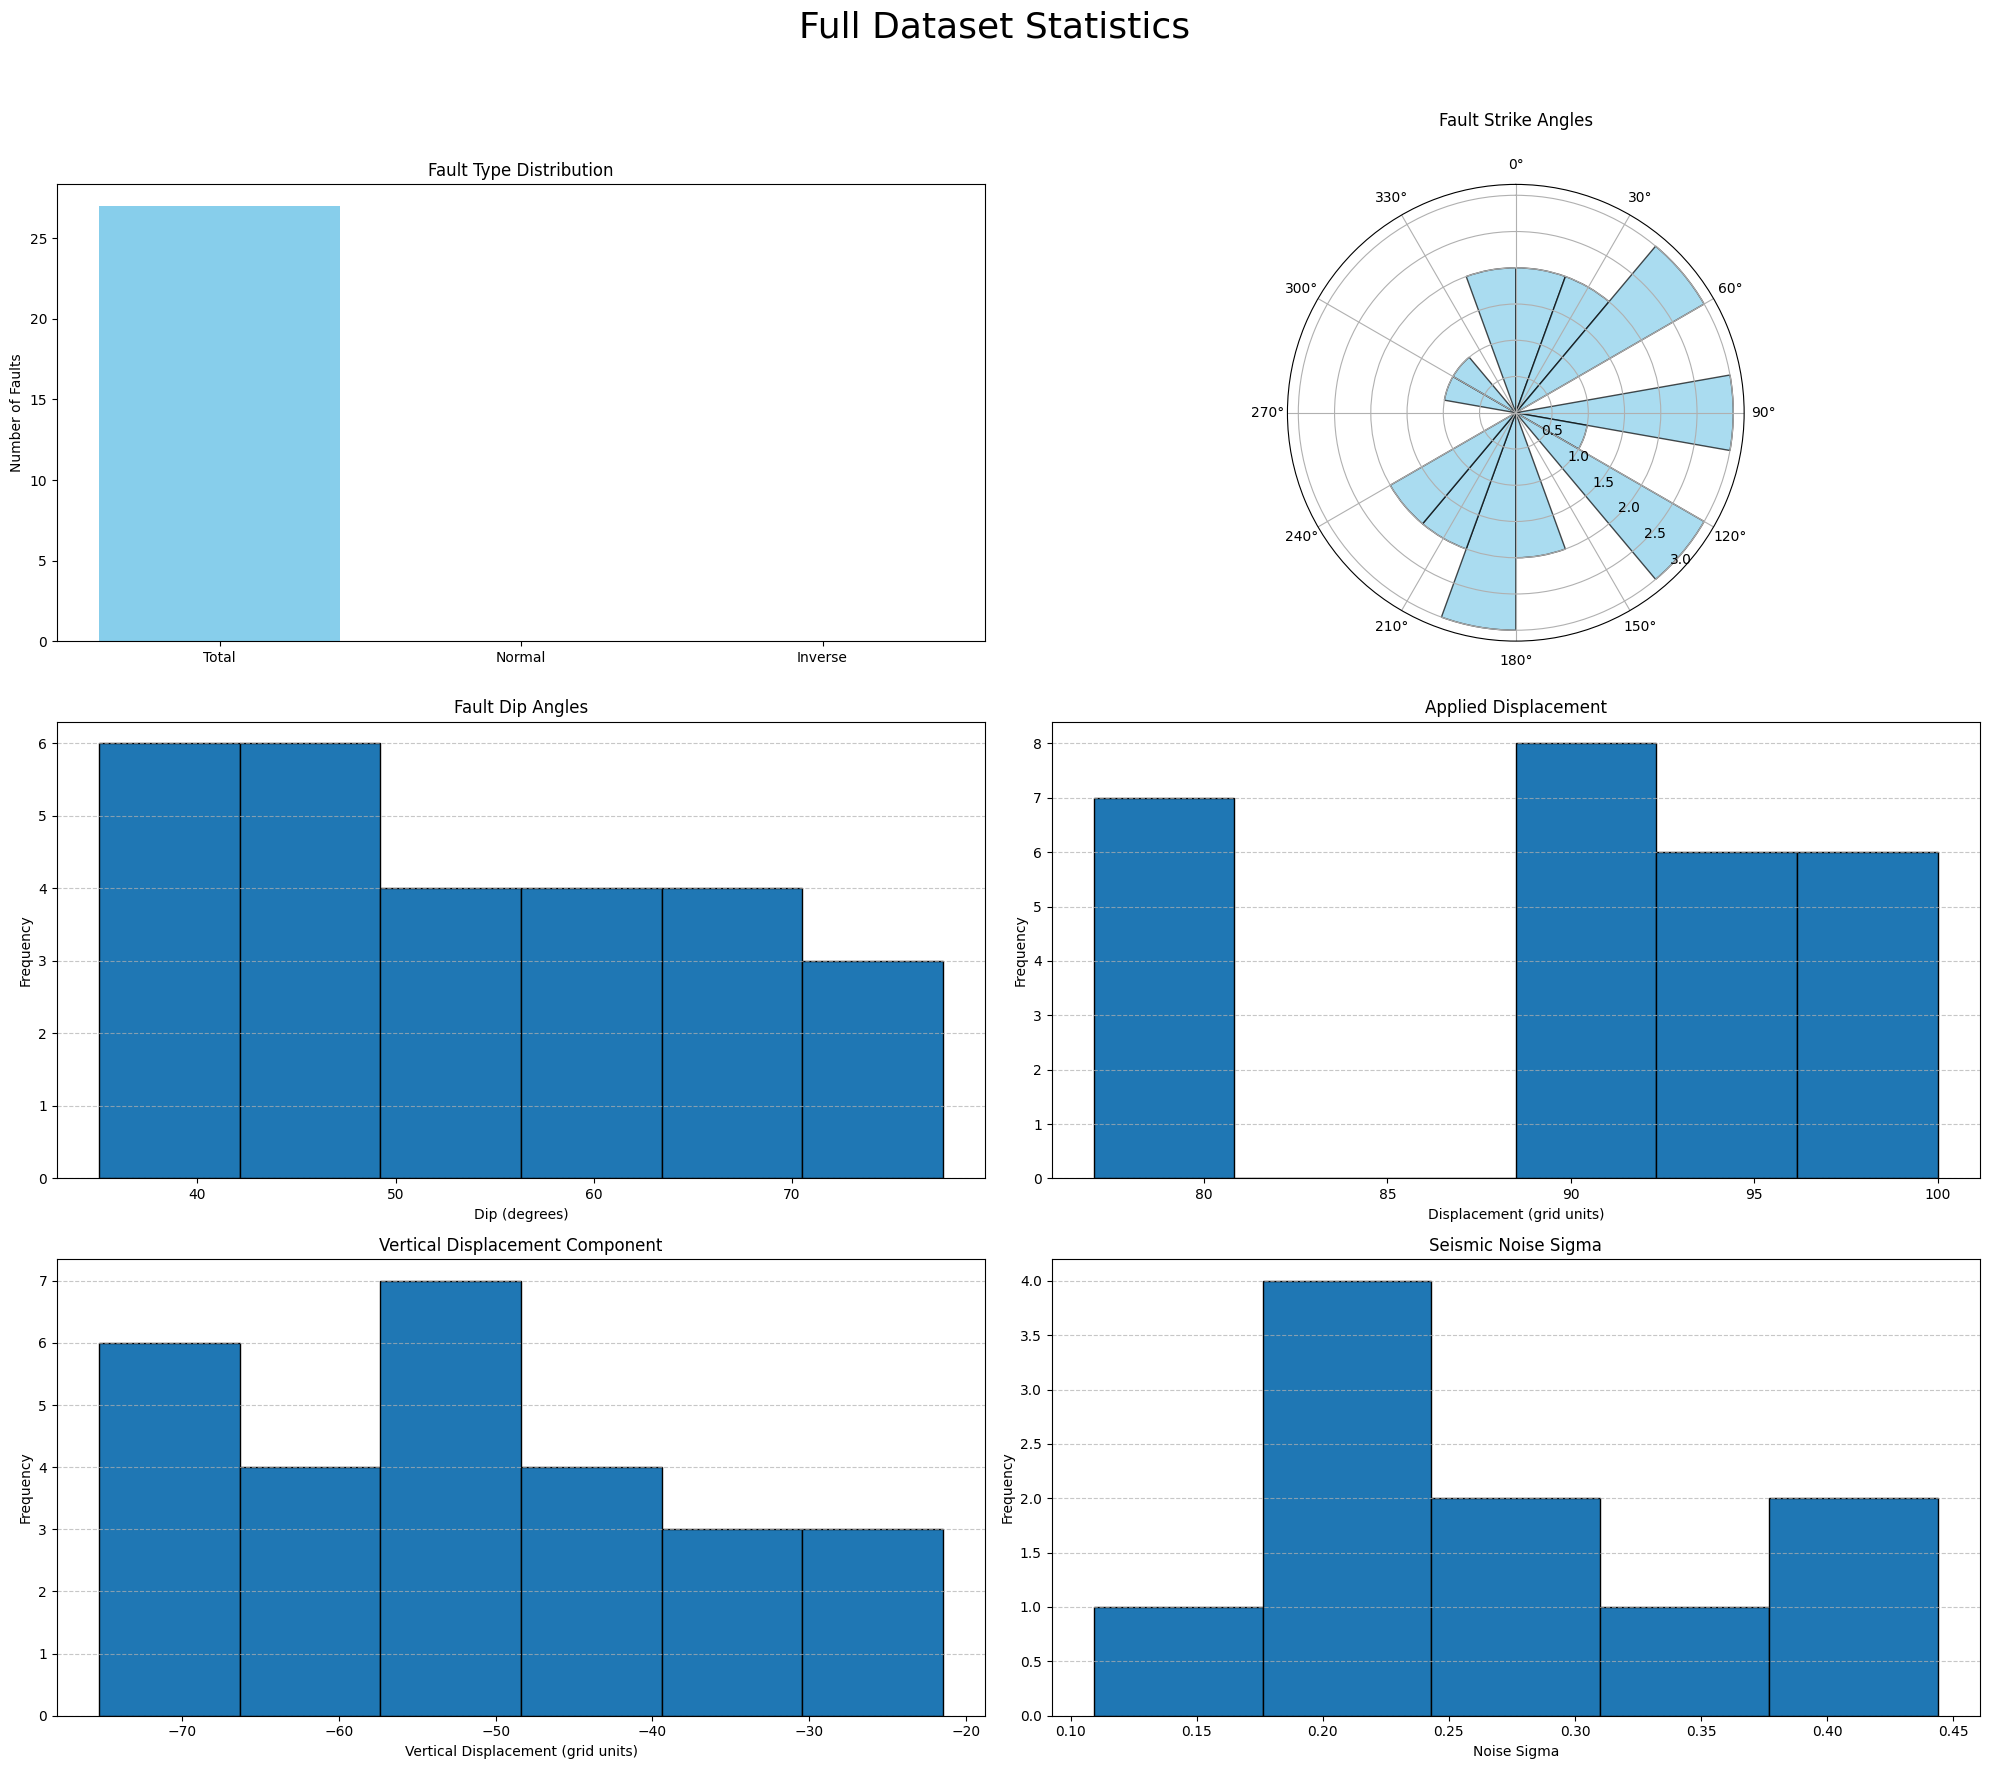


--- Displaying Statistics and Plots for train data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count   7.000000     7.000000       7.000000              7.000000   
mean   22.767118     0.279474       7.142857              3.000000   
std     7.267428     0.115036       3.184785              1.290994   
min    11.227347     0.109171       2.000000              1.000000   
25%    18.802065     0.215150       5.000000              2.000000   
50%    23.395202     0.265183       9.000000              4.000000   
75%    26.946085     0.353873       9.500000              4.000000   
max    33.250980     0.443913      10.000000              4.000000   

       max_disp_used  
count       7.000000  
mean       92.285714  
std         6.872998  
min        79.000000  
25%        90.500000  
50%        93.000000  
75%        96.500000  
max       100.000000  


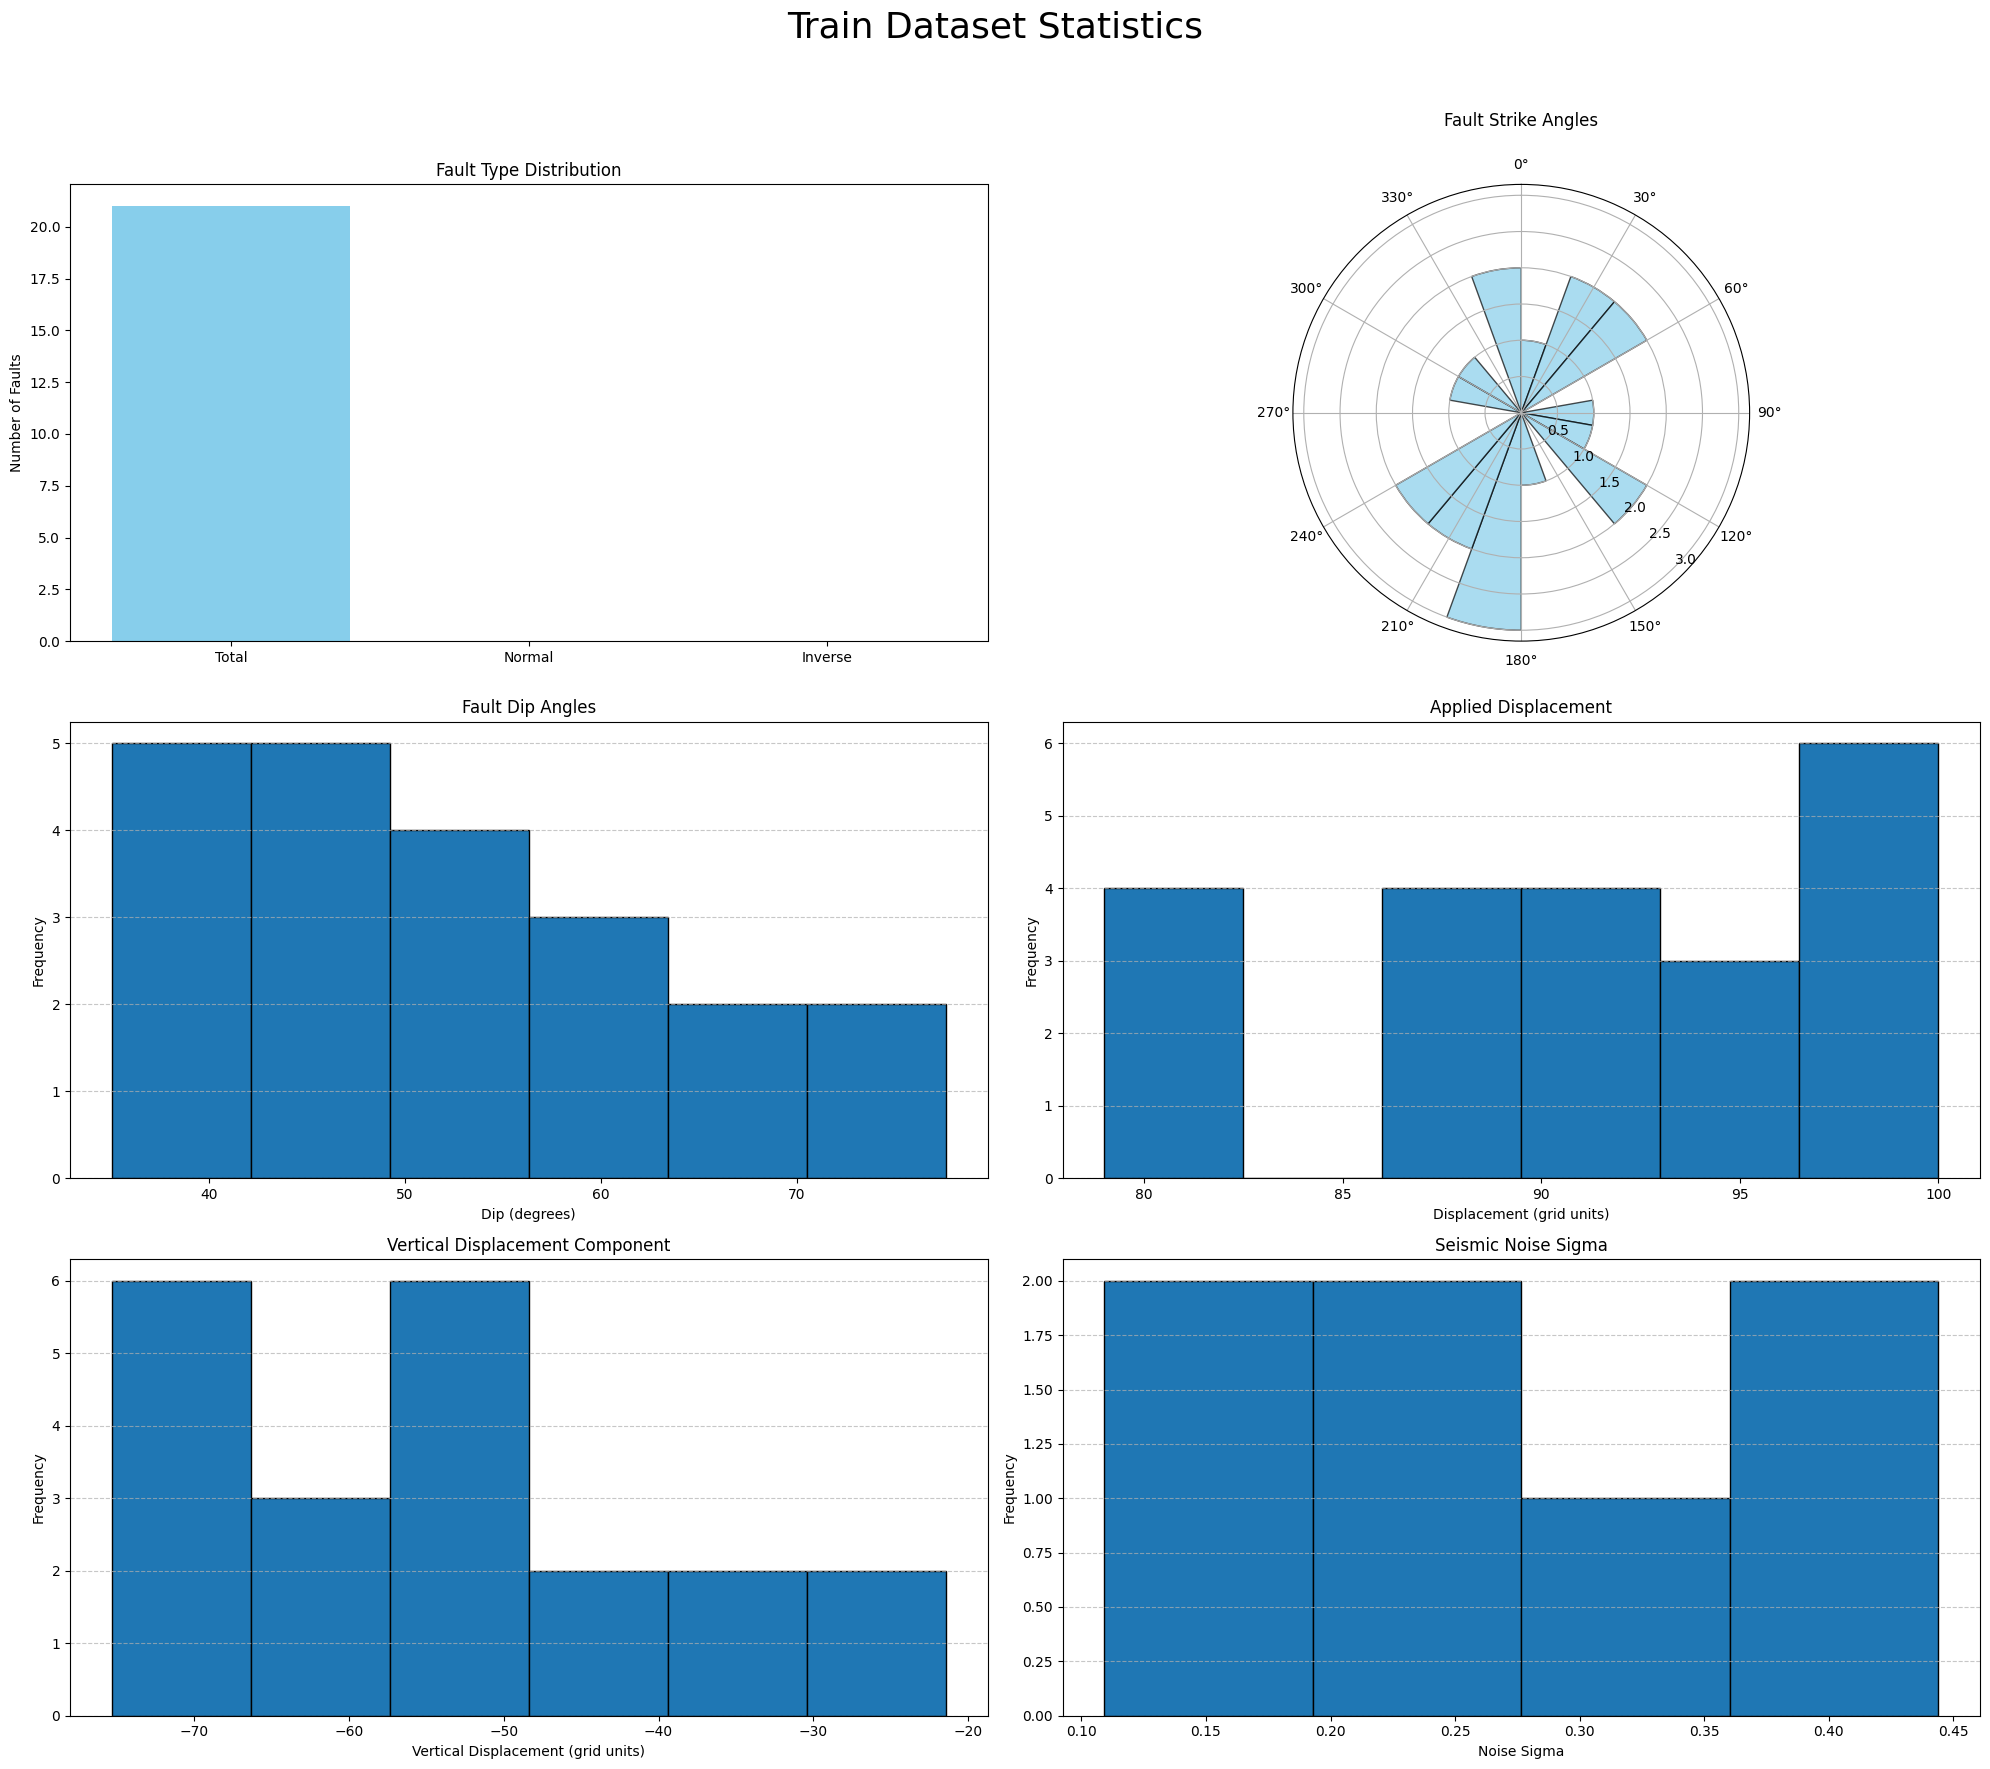


--- Displaying Statistics and Plots for validation data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count   3.000000     3.000000       3.000000              3.000000   
mean   20.641547     0.217202       5.000000              2.000000   
std     8.662380     0.009328       4.358899              1.732051   
min    11.715816     0.206458       2.000000              0.000000   
25%    16.455292     0.214181       2.500000              1.500000   
50%    21.194767     0.221903       3.000000              3.000000   
75%    25.104412     0.222574       6.500000              3.000000   
max    29.014057     0.223244      10.000000              3.000000   

       max_disp_used  
count       3.000000  
mean       82.666667  
std        10.692677  
min        76.000000  
25%        76.500000  
50%        77.000000  
75%        86.000000  
max        95.000000  


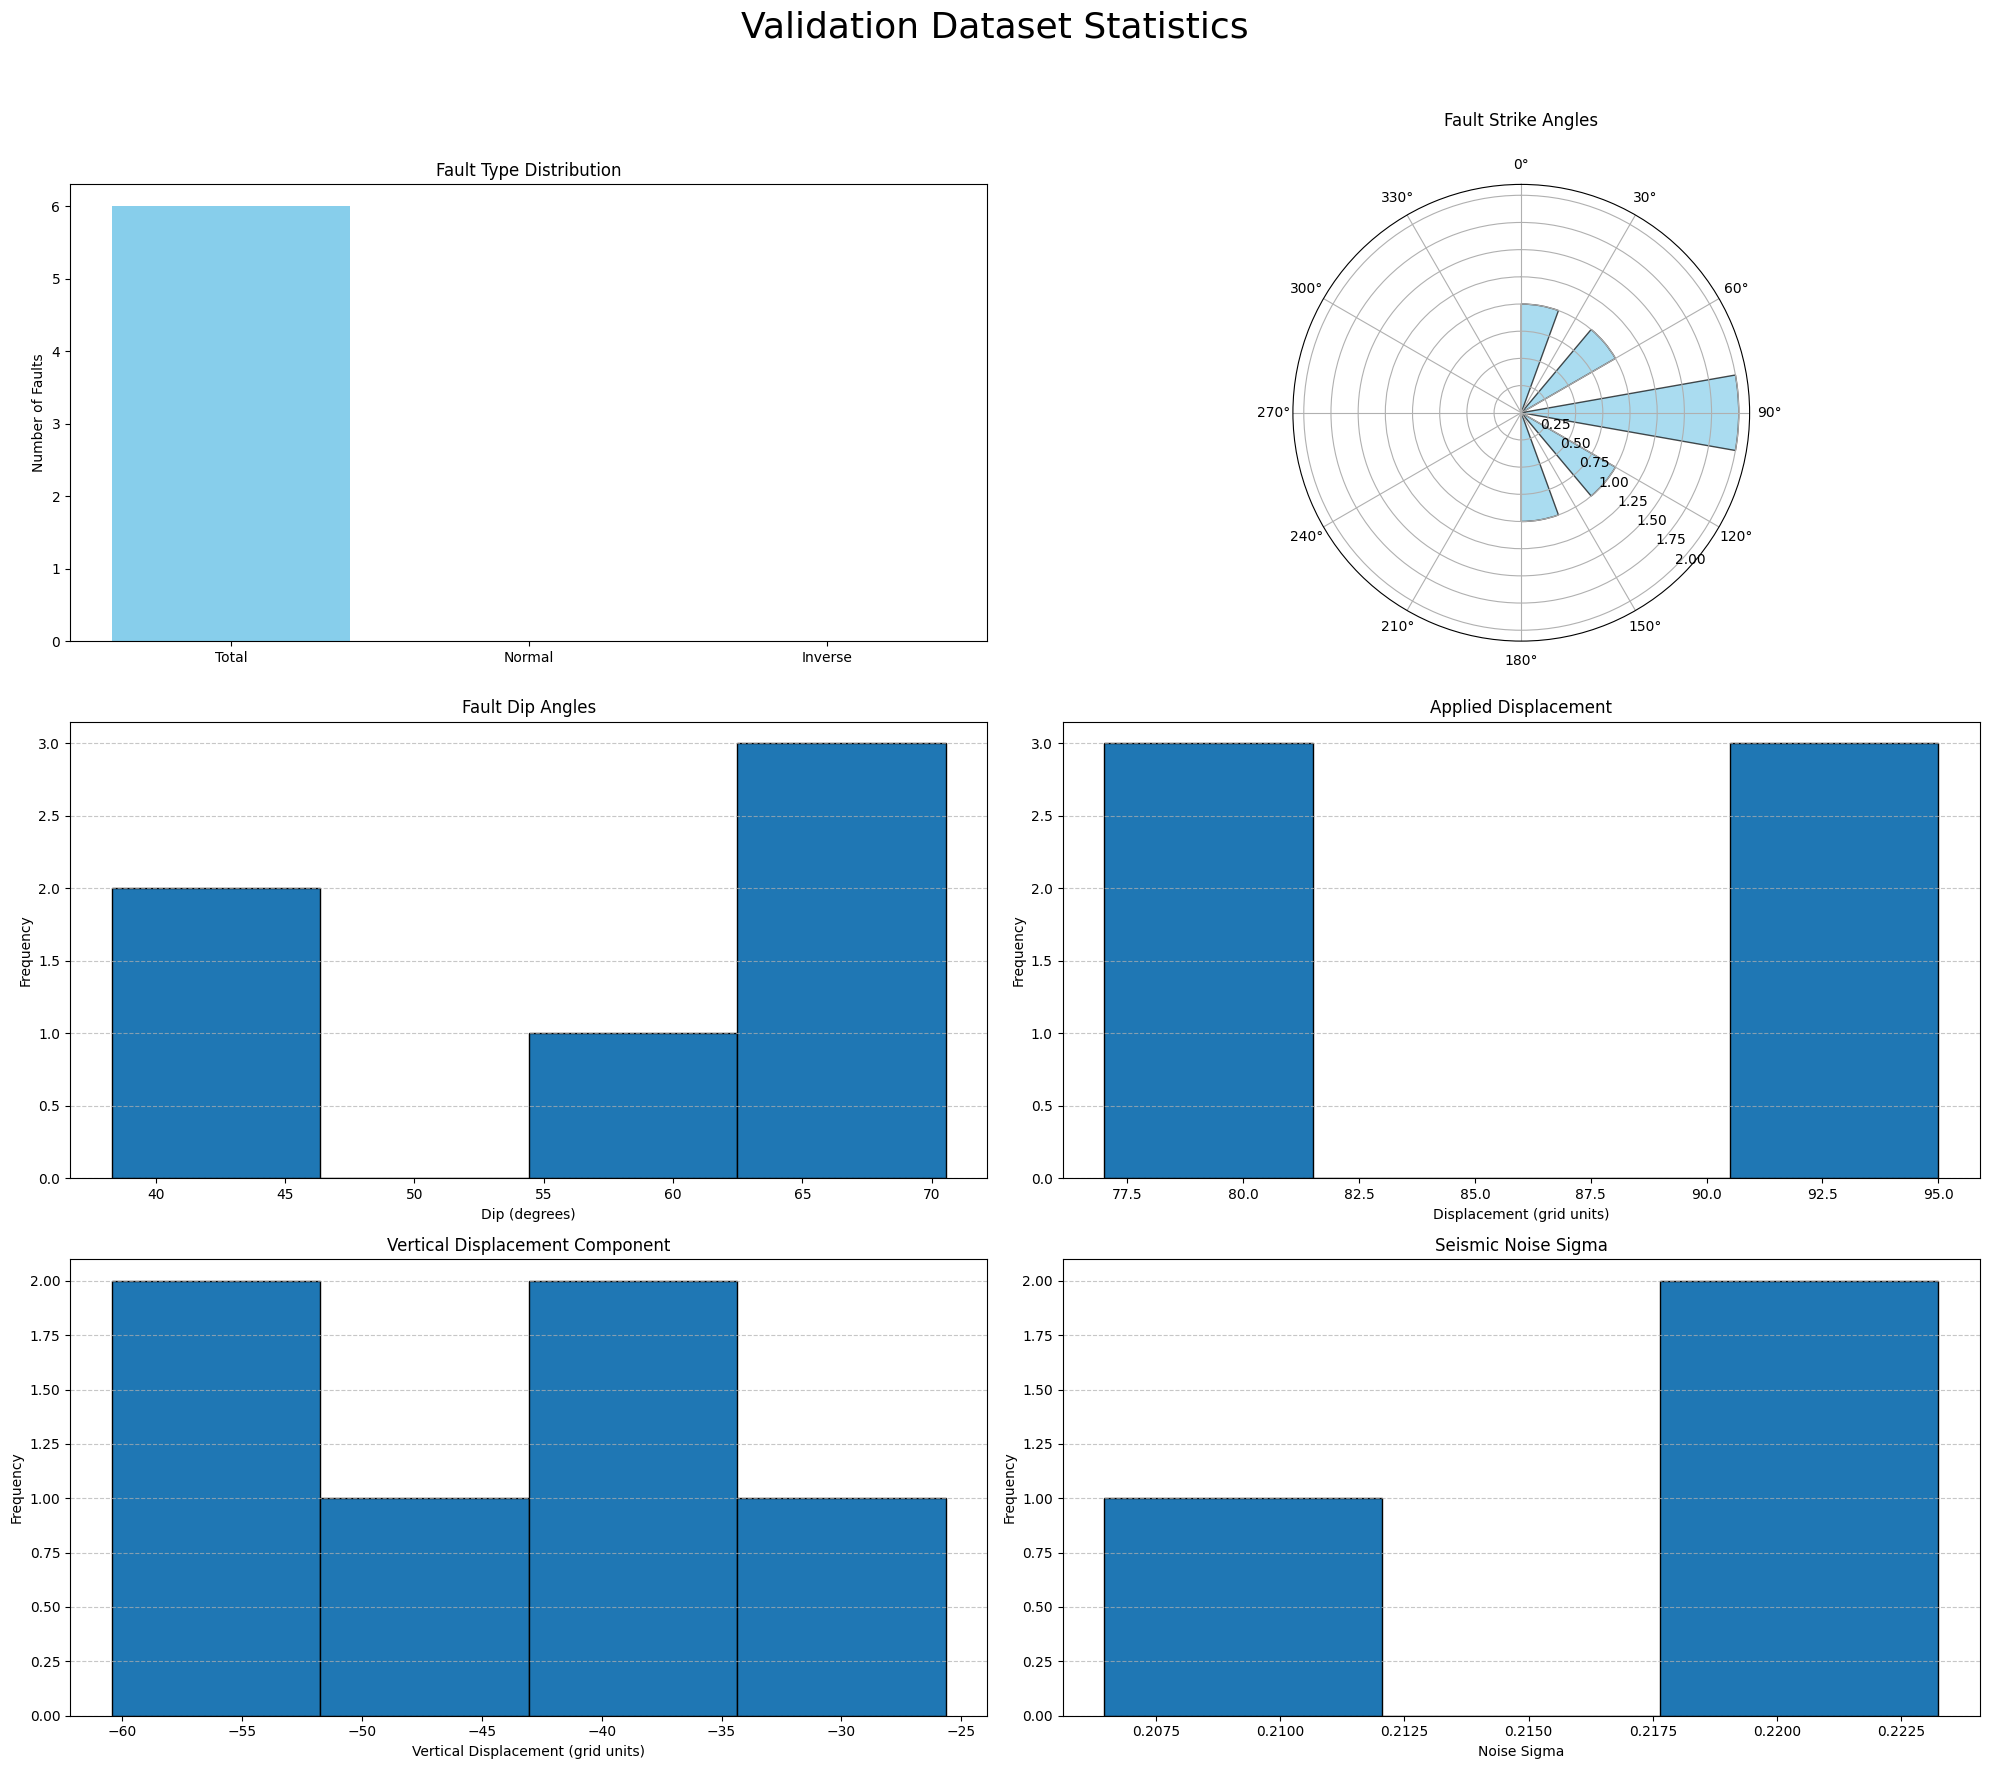

In [9]:
# ─── 3) Display Statistics and Plots for All Splits Individually ──────────────────────────────

for split_name in ['full', 'train', 'validation']:
    stats = all_stats_data.get(split_name)
    print(f"\n--- Displaying Statistics and Plots for {split_name} data ---")

    if not stats or 'cube_level_params' not in stats or 'all_fault_params' not in stats:
        print(f"No statistics available for '{split_name}' split.")
        continue

    # Extract parameters for the current split
    cube_level_params = stats['cube_level_params']
    all_fault_params = stats['all_fault_params']

    # Create a summary DataFrame
    df = pd.DataFrame(cube_level_params)
    print("\nCube Generation Parameter Summary:")
    print(df.describe())

    # --- Generate and Display Plots ---
    if not all_fault_params:
        print("\nNo fault parameters to plot for this split.")
        continue

    # Extract fault-specific data for plotting
    strikes = [f['strike'] for f in all_fault_params]
    dips = [f['dip'] for f in all_fault_params]
    displacements = [f['applied_disp_signed'] for f in all_fault_params]
    vertical_displacements = [f['vertical_disp_component'] for f in all_fault_params]
    noise_sigmas = [p.get('noise_sigma') for p in cube_level_params]

    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(20, 18))
    fig.suptitle(f"{split_name.capitalize()} Dataset Statistics", fontsize=26)
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

    # Plot Fault Counts
    ax1 = fig.add_subplot(gs[0, 0])
    normal_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
    inverse_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')
    ax1.bar(['Total', 'Normal', 'Inverse'], [len(all_fault_params), normal_count, inverse_count], color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title(f'Fault Type Distribution')
    ax1.set_ylabel('Number of Faults')

    # Plot Strike Rose Diagram
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    if strikes:
        plot_rose_diagram(strikes, ax=ax2, title='Fault Strike Angles')

    # Plot Dip Histogram
    ax3 = fig.add_subplot(gs[1, 0])
    if dips:
        plot_histogram(dips, ax=ax3, title='Fault Dip Angles', xlabel='Dip (degrees)')

    # Plot Displacement Histogram
    ax4 = fig.add_subplot(gs[1, 1])
    if displacements:
        plot_histogram(displacements, ax=ax4, title='Applied Displacement', xlabel='Displacement (grid units)')

    # Plot Vertical Displacement Histogram
    ax5 = fig.add_subplot(gs[2, 0])
    if vertical_displacements:
        plot_histogram(vertical_displacements, ax=ax5, title='Vertical Displacement Component', xlabel='Vertical Displacement (grid units)')

    # Plot Noise Sigma Histogram
    ax6 = fig.add_subplot(gs[2, 1])
    if any(n is not None for n in noise_sigmas):
        plot_histogram([n for n in noise_sigmas if n is not None], ax=ax6, title='Seismic Noise Sigma', xlabel='Noise Sigma')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

---

In [10]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

---

---

### 3D Visualization

In [11]:
# PARAMETERS
cube_size = 128  # or whatever you used
mask_mode = 0    # or 1
#base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

In [12]:
# Function to normalize to 0-255 uint8
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Function to plot fault points
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))

In [13]:
# PARAMETERS
cube_size = 128  # Adjust as needed
mask_mode = 0    # 0 = binary masks; 1 = multiclass
#base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

# Normalization helper
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Fault plotting function
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))

# Loop over splits
for split in ["train", "validation"]:
    seismic_dir = os.path.join(base_out, split, "seis")
    mask_dir = os.path.join(base_out, split, "fault")

    if not (os.path.exists(seismic_dir) and os.path.exists(mask_dir)):
        print(f"[{split}] Skipping: directories not found.")
        continue

    files = sorted(set(os.listdir(seismic_dir)).intersection(os.listdir(mask_dir)))
    if not files:
        print(f"[{split}] No files to visualize.")
        continue

    selected_file = random.choice([f for f in files if f.endswith((".npy", ".dat"))])
    print(f"[{split}] Selected file: {selected_file}")

    # Load data
    seismic_path = os.path.join(seismic_dir, selected_file)
    mask_path = os.path.join(mask_dir, selected_file)

    if selected_file.endswith(".npy"):
        seismic = np.load(seismic_path)
        mask = np.load(mask_path)
    else:
        seismic = np.fromfile(seismic_path, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
        mask = np.fromfile(mask_path, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))

    nx, ny, nz = seismic.shape

    # Slices
    inline     = seismic[nx//2,:,:].T
    crossline  = seismic[:,ny//2,:].T
    timeslice  = seismic[:,:,nz//2]

    inline_m   = mask[nx//2,:,:].T
    cross_m    = mask[:,ny//2,:].T
    timeslice_m= mask[:,:,nz//2]

    inline_norm    = normalize(inline)
    crossline_norm = normalize(crossline)
    timeslice_norm = normalize(timeslice)

    # Create 3D figure
    fig = go.Figure()

    # Seismic surfaces
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (ny, 1)).T,
        x=np.full((nz, ny), nx//2),
        y=np.tile(np.arange(ny), (nz, 1)),
        surfacecolor=inline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (nx, 1)).T,
        x=np.tile(np.arange(nx), (nz, 1)),
        y=np.full((nz, nx), ny//2),
        surfacecolor=crossline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.full((ny, nx), nz//2),
        x=np.tile(np.arange(nx), (ny, 1)),
        y=np.tile(np.arange(ny).reshape(-1,1), (1, nx)),
        surfacecolor=np.rot90(timeslice_norm, k=-1),
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))

    # Fault overlays
    if mask_mode == 0:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "white", "Inline Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "white", "Crossline Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "white", "Time-Slice Faults", nx, ny, nz)
    elif mask_mode == 1:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "green", "Inline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, inline_m==2, nx//2, "inline", "purple", "Inline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "green", "Crossline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==2, ny//2, "crossline", "purple", "Crossline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "green", "Time-Slice Normal Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==2, nz//2, "timeslice", "purple", "Time-Slice Inverse Faults", nx, ny, nz)

    # Layout
    fig.update_layout(
        title=f"3D Fault Visualization — {split.upper()} / {selected_file}",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

[train] Selected file: 4.npy


[validation] Selected file: 7.npy
